In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from data_generation import *
from torchvision import transforms
from PIL import Image, ImageDraw

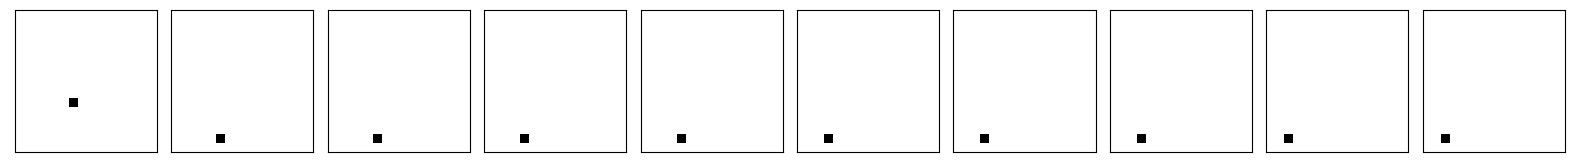

[(6.118723977510821, 5.050649633235524), (5.677215560876097, 1.6532339699126974), (5.235707144241373, 1.9665955923149168), (4.794198727606649, 1.4985884051982148), (4.3526903109719255, 1.498785460924016), (3.9111818943372016, 1.498785460924016), (3.469673477702478, 1.498785460924016), (3.028165061067754, 1.498785460924016), (2.58665664443303, 1.498785460924016), (2.1451482277983063, 1.498785460924016)]


In [4]:
sequence, positions = generate_random_sequence()
display_sequence(sequence)
print(positions)

In [5]:
# Hyperparameters
N = 1000  # Number of sequences
L = 10  # Length of each sequence
H, W = 16, 16  # Dimensions of the images
batch_size = 32
learning_rate = 0.001
num_epochs = 20


# Data Generation
class PixelDataset(Dataset):
    def __init__(self, num_sequences, sequence_length):
        self.data = []
        self.targets = []
        for _ in range(num_sequences):
            images, positions = generate_random_sequence()
            self.data.append(images)  # Store the whole sequence
            self.targets.append(positions)  # Store all positions

        self.transform = transforms.ToTensor()
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Transform and stack images to create a sequence
        sequence_of_images = [self.transform(image) for image in self.data[idx]]
        sequence_of_images = torch.stack(sequence_of_images)

        # Stack target positions
        target_positions = torch.FloatTensor(self.targets[idx])

        return sequence_of_images, target_positions


# Creating Dataset and DataLoader
dataset = PixelDataset(N, L)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
class SimpleTransformer(nn.Module):
    def __init__(self):
        super(SimpleTransformer, self).__init__()
        self.encoder = nn.TransformerEncoderLayer(d_model=H * W, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder, num_layers=3)
        self.fc = nn.Linear(H * W, 2)  # Output is x, y position

    def forward(self, x):
        # Flatten the image and encode
        batch_size, sequence_length, _, _, _ = x.size()
        x = x.view(batch_size, sequence_length, -1)
        encoded = self.transformer_encoder(x)
        output = self.fc(encoded)  # Apply the linear layer to the entire sequence
        return output


def euclidean_distance_loss(output, target):
    epsilon = 1e-6  # A small constant to avoid sqrt(0)
    return torch.sqrt(torch.sum((output - target) ** 2, dim=-1) + epsilon).mean()


model = SimpleTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = euclidean_distance_loss

for epoch in range(num_epochs):
    for images, positions in dataloader:
        # Shift the positions by one to create the targets
        targets = torch.roll(positions, -1, dims=1)

        # Mask the last position in each sequence as it has no valid next position
        mask = torch.zeros_like(targets)
        mask[:, :-1, :] = 1  # Mask all but the last position

        # Forward pass
        predicted_positions = model(images)

        # Apply the mask
        masked_predicted = predicted_positions * mask
        masked_targets = targets * mask

        # Compute loss
        loss = criterion(masked_predicted, masked_targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/20], Loss: 2.4393
Epoch [2/20], Loss: 2.0480
Epoch [3/20], Loss: 1.0963
Epoch [4/20], Loss: 1.7283
Epoch [5/20], Loss: 0.8799
Epoch [6/20], Loss: 1.4094
Epoch [7/20], Loss: 0.9298
Epoch [8/20], Loss: 1.2095
Epoch [9/20], Loss: 0.9576
Epoch [10/20], Loss: 1.0218
Epoch [11/20], Loss: 0.4336
Epoch [12/20], Loss: 0.6249
Epoch [13/20], Loss: 0.6877
Epoch [14/20], Loss: 0.7807
Epoch [15/20], Loss: 0.6369
Epoch [16/20], Loss: 0.7651
Epoch [17/20], Loss: 0.5060
Epoch [18/20], Loss: 0.6236
Epoch [19/20], Loss: 0.5601
Epoch [20/20], Loss: 0.5454


In [43]:
def predict_sequence(model, sequence_of_images, device):
    """
    Predict the positions for a given sequence of images.

    :param model: Trained PyTorch model.
    :param sequence_of_images: A sequence of images as a PyTorch tensor.
    :param device: Device to perform computations on (e.g., 'cuda', 'cpu').
    :return: Predicted positions as a tensor.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        sequence_of_images = sequence_of_images.to(device)
        predicted_positions = model(sequence_of_images)
    return predicted_positions.cpu()


def create_images_from_positions(positions, image_size=(16, 16)):
    """
    Create a sequence of PIL images from a sequence of position tuples.

    :param positions: A sequence of (x, y) tuples.
    :param image_size: Size of the output images (width, height).
    :return: A list of PIL.Image.Image objects.
    """
    images = []
    for pos in positions:
        img = Image.new("L", image_size, 255)  # Create a white image
        draw = ImageDraw.Draw(img)
        x, y = pos
        draw.point((x, y), fill=0)  # Draw the black pixel
        images.append(img)
    return images

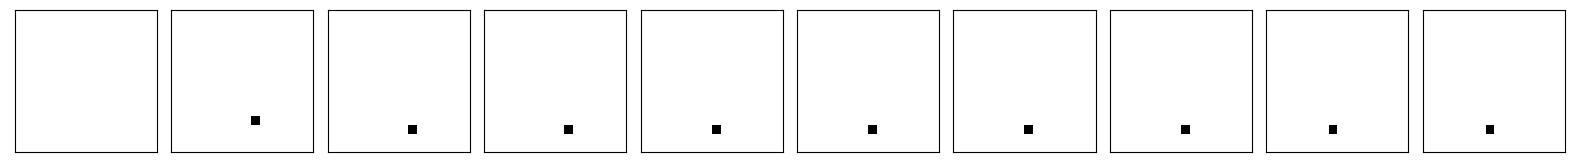

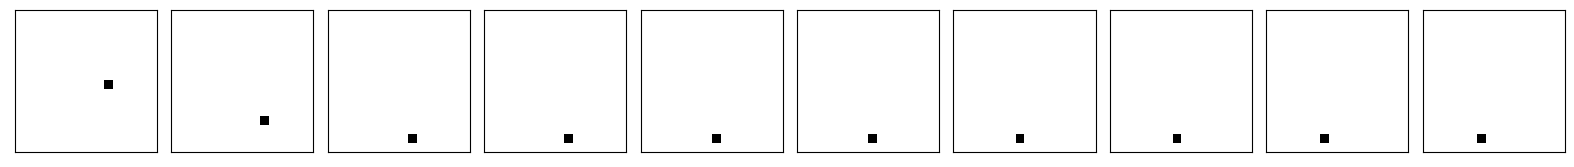

In [44]:
sequence, positions = generate_random_sequence()
sequence_of_images = prepare_sequence_for_model(sequence)
predicted_positions = predict_sequence(
    model, sequence_of_images, device="cpu"
)  # or 'cuda'
predicted_positions = predicted_positions[:, 1:, :]
predicted_images = create_images_from_positions(predicted_positions)